In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import model_to_hdulist, obs_coronagraphy
from pynrc.obs_nircam import plot_contrasts, planet_mags, plot_planet_patches

from pynrc.speckle_noise import offset_bar
pynrc.setup_logging('WARNING', verbose=False)

from astropy.io import (fits, ascii)

# Observation Definitions

Functions to create at optimize a series of observation objects stored as a dictionary.

In [3]:
def make_key(filter, pupil=None, mask=None):
    """Create identification key (string) based on filter, pupil, and mask"""
    mask_key = 'none' if mask is None else mask
    pupil_key = 'none' if pupil is None else pupil
    key = '{}_{}_{}'.format(filter,mask_key,pupil_key)
    return key

In [4]:
def obs_wfe(wfe_ref_drift, filt_list, dist, sp_ref=None, args_disk=None, fov_pix=None, verbose=False):
    """
    For a given WFE drift and series of filters, create a list of 
    NIRCam observations.
    """
    
    if sp_ref is None:
        sp_ref = sp_sci

    fov_pix_orig = fov_pix
        
    obs_dict = {}
    for filt, mask, pupil in filt_list:
        if verbose: print(filt, mask, pupil)
        
        # Disk Model
        if args_disk is not None:
            # Convert to photons/sec in specified filter
            hdu_disk = model_to_hdulist(args_disk, sp_sci, filt, pupil=pupil, mask=mask)
        else:
            hdu_disk = None
        
        # Create identification keys
        key = make_key(filt, mask=mask, pupil=pupil)

        # Define the subarray readout size
        # Set the PSF size and oversampling amount
        if mask is None:
            subsize = 400
        elif ('MASK210R' in mask) or ('MASKSWB' in mask):
            subsize = 640
        else:
            subsize = 320
        fov_pix = subsize if fov_pix is None else fov_pix
        
        # Offset for bar mask
        if (mask is not None) and ('WB' in mask):
            offset_r, offset_theta = offset_bar(filt, mask)
        else:
            offset_r, offset_theta = (None, None)

        # Other coronagraph vs direct imaging settings
        if mask is None:
            module = 'B'
            oversample = 4
        else:
            module = 'A'
            oversample = 2
            
        # Initialize and store the observation
        # A reference obseration is stored inside each parent obs_coronagraphy class.
        obs_dict[key] = obs_coronagraphy(sp_sci, sp_ref, dist, module=module, disk_hdu=hdu_disk, 
                                         wfe_ref_drift=wfe_ref_drift, filter=filt, mask=mask, pupil=pupil, 
                                         wind_mode='WINDOW', xpix=subsize, ypix=subsize,
                                         offset_r=offset_r, offset_theta=offset_theta,
                                         oversample=oversample, fov_pix=fov_pix, verbose=verbose)
        fov_pix = fov_pix_orig
    return obs_dict

## Functions to init, optimize, and plot

In [5]:
# Generate initial observations for each filter(no WFE drift)
def do_init(args_disk=None, fov_pix=None, verbose=True):
    wfe_ref_drift = 0
    obs_dict = obs_wfe(wfe_ref_drift, args_list, dist_sci, sp_ref=sp_ref, 
                       args_disk=args_disk, fov_pix=fov_pix, verbose=verbose)
    return obs_dict

In [6]:
# For each filter setting, generate a series of contrast curves at different WFE values
def do_contrast(wfe_list, filt_keys, nsig=5, roll_angle=None, **kwargs):
    """
    kwargs to pass to calc_contrast() and their defaults:

    exclude_disk = True
    exclude_planets = True
    exclude_noise = False
    opt_diff = True
    """
    contrast_all = {}
    for i, key in enumerate(filt_keys):
        print(key)
        obs = obs_dict[key]

        filt, mask, pupil = args_list[i]
        if roll_angle is None:
            roll_angle = 0 if mask is None else 10

        # Stores tuple of (Radial Distances, Contrast, and Sensitivity) for each WFE drift
        curves = []
        for wfe_ref_drift in wfe_list:
            obs.wfe_ref_drift = wfe_ref_drift
            result = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig, **kwargs)
            curves.append(result)

        contrast_all[key] = curves
    return contrast_all

In [7]:
def do_plot_contrast(obs, curves, wfe_list, nsig, age, xlim=[0,10], ylim=[24,8], save_fig=False):

    fig, axes = plt.subplots(1,2, figsize=(13,4.5))
    entropy_vals = [13,8]

    for j, ax in enumerate(axes.flatten()):
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        plot_contrasts(curves, wfe_list, ax=ax)
        plot_planet_patches(ax, obs, age=age, entropy=entropy_vals[j])

    for ax in axes.flatten():
        ax.set_xlabel('Distance (arcsec)')
        ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.legend(ncol=2)

    fig.tight_layout()
    
    dist = obs.distance
    age_str = 'Age = {:.0f} Myr'.format(age)
    dist_str = 'Distance = {:.1f} pc'.format(dist) if dist is not None else ''
    
    fig.suptitle('{} ({}, {})'.format(name_sci,age_str,dist_str), fontsize=16);
    #fig.subplots_adjust(top=0.85)
    fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.1 , left=0.05, right=0.97)

    fname = "{}_contrast.pdf".format(name_sci.replace(" ", ""))
    if save_fig: 
        fig.savefig(outdir+fname)

In [8]:
def do_gen_hdus(obs_dict, wfe_ref_drift, verbose=False, **kwargs):
    
    """
    kwargs to pass to gen_roll_image() and their defaults:
    
    PA1 = 0
    PA2 = 10
    zfact         = None
    oversample    = None
    exclude_disk  = False
    exclude_noise = False
    opt_diff      = True
    """
    
    hdulist_dict = {}
    for key in filt_keys:
        if verbose: print(key)
        obs = obs_dict[key]
        obs.wfe_ref_drift = wfe_ref_drift
        hdulist = obs.gen_roll_image(**kwargs)
        
        hdulist_dict[key] = hdulist
        
    return hdulist_dict

## Science spectral model

In [9]:
# Final science spectrum is the stellar spectrum tagged at V-Band
# with a modified blackbody added on top
def bb_jy(wave, T):
    """
    For a given set of wavelengths and a Temperature, return
    the blackbody function in units of Jy.
    """
    
    # Physical Constants
    H  = 6.62620000E-27  # Planck's constant in cgs units
    HS = 6.62620000E-34  # Planck's constant in standard units
    C  = 2.99792458E+08  # speed of light in standard units
    K  = 1.38064852E-23  # Boltzmann constant in standard units

    # Blackbody coefficients (SI units)
    C1 = 2.0 * HS * C    # Power * unit area / steradian
    C2 = HS * C / K   

    w_m = wave * 1e-6

    exponent = C2 / (w_m * T)
    expfactor = np.exp(exponent)

    return 1.0E+26 * C1 * (w_m**-3.0) / (expfactor - 1.0)

def func_model(x, sp):
    bb_flux = x[0] * bb_jy(sp.wave/1e4, x[1]) * (sp.wave/1e4)**x[2] / 1e17
    sp_bb = S.ArraySpectrum(sp.wave, bb_flux, fluxunits='Jy')
    sp_bb.convert('Flam')
    
    f1 = sp.flux
    f2 = sp_bb.flux
    
    ftot = f1 + f2 
    
    sp_res = S.ArraySpectrum(sp.wave, ftot, fluxunits='Flam')
    
    return sp_res

def func_resid(x, sp_phot, sp_star):
    sp_model = func_model(x,sp_star)
    
    wvals = sp_phot.wave
    ind = (wvals < 30e4)
        
    wvals = wvals[ind]
    yvals = sp_phot.flux[ind]
    
    mod_interp = np.interp(wvals, sp_star.wave, sp_model.flux)
    return 1e15*(mod_interp - yvals)



In [10]:
from scipy.optimize import least_squares
def gen_sp_sci(i, robust=False, return_ax=False, plot=True):
    name_sci, dist_sci, age_sci, spt_sci, vmag_sci, kmag_sci, w1_sci, w2_sci, vot = args_sources[i]

    # Import source SED from VOTable
    from astropy.io.votable import parse, parse_single_table
    table = parse_single_table(vot)
    freq = table.array["sed_freq"] * 1e9 # Hz
    isort = np.argsort(1/freq)

    # Sort flux monotomically with wavelength
    freq = freq[isort]
    flux = table.array["sed_flux"][isort]
    eflux = table.array["sed_eflux"][isort]

    # Average duplicate data points
    ufreq, ucnt = np.unique(freq, return_counts=True)
    ufreq = ufreq[::-1]
    ucnt = ucnt[::-1]

    uflux = []
    for i, f in enumerate(ufreq):
        ind = (freq==f)
        flx = np.median(flux[ind]) if ucnt[i]>1 else flux[ind]
        uflux.append(flx)
    uflux = np.array(uflux)

    # Photometric data points
    sp_phot = S.ArraySpectrum(ufreq, uflux, waveunits='Hz', fluxunits='Jy')
    sp_phot.convert('Angstrom')
    sp_phot.convert('Flam')

    # Stellar spectrum normalized at V-Band
    sp_star = pynrc.stellar_spectrum(spt_sci, vmag_sci, 'vegamag', bp_v)
    

    x0 = [1, 2000, 0]
    loss = 'soft_l1' if robust else 'linear'
    res = least_squares(func_resid, x0, args=(sp_phot, sp_star), bounds=(0,np.inf),
                        loss=loss)
    out = res.x
    print(out)
    
    sp_sci = func_model(out, sp_star)
    sp_sci.name = name_sci

    if plot:
        fig, ax = plt.subplots(1,1, figsize=(8,5))
        ax.loglog(sp_star.wave/1e4, sp_star.flux, lw=1, label='Photosphere')
        ax.loglog(sp_sci.wave/1e4, sp_sci.flux, lw=2, label='Model Fit')
        ax.loglog(sp_phot.wave/1e4, sp_phot.flux, marker='o', ls='none', label='Photometry')
        ax.set_xlabel('Wavelength (microns)')
        ax.set_ylabel('Flux ({})'.format(sp_sci.fluxunits))
        ax.set_title(name_sci)
        fig.tight_layout()
    
        if return_ax:
            return (sp_sci, (fig,ax))
        else:
            return sp_sci
    else:
        return sp_sci


## Define Source and their Reference Counterparts

In [11]:
#                source,      dist, age, sptype, vmag kmag  W1   W2
args_sources = [('SAO 206462', 140,  10, 'F8V',  8.7, 5.8, 5.0, 4.0, 'YSOs/SAO206462.vot'),
                ('TW Hya',      54,  10, 'M0V', 11.0, 7.3, 7.0, 6.9, 'YSOs/TWHya.vot'),
                ('MWC 758',    150,   5, 'A5V',  8.3, 5.7, 4.6, 3.5, 'YSOs/MWC758.vot'), # Lazareff et al. (2016)
                ('HL Tau',     140,   1, 'K5V', 15.1, 7.4, 5.2, 3.3, 'YSOs/HLTau.vot')]

# Corresponding reference stars
#ref_sources =  [('GJ 588', 'M2V', 4.6),
#                ('GJ 588', 'M2V', 4.6),
#                ('HR 1889',  'F5III', 5.4),
#                ('HR 1889',  'F5III', 5.4)]

ref_sources =  [('HD 94771', 'G4V', 5.6),
                ('HD 94771', 'G4V', 5.6),
                ('HR 1889',  'F5III', 5.4),
                ('HR 1889',  'F5III', 5.4)]

outdir = 'YSOs/'

In [12]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

# List of filters
args_list =  [('F187N', None, None),
              ('F200W', None, None),
              ('F356W', None, None),
              ('F444W', None, None)]

#args_list =  [('F300M', None, None),
#              ('F356W', None, None),
#              ('F356W', 'MASK430R', 'CIRCLYOT'),
#              ('F430M', None, None),
#              ('F444W', None, None),
#              ('F444W', 'MASK430R', 'CIRCLYOT')]


filt_keys = []
for (filt,mask,pupil) in args_list:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

## 1. SAO 206462

[  1.20751698e+00   1.91598941e+03   5.34940819e-01]


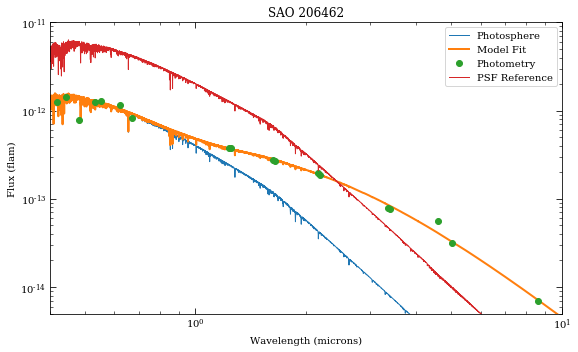

In [71]:
i = 0

name_sci, dist_sci, age_sci, spt_sci, vmag_sci, kmag_sci, w1_sci, w2_sci, vot = args_sources[i]
name_ref, spt_ref, kmag_ref = ref_sources[i]

# Science target and reference star spectra
sp_ref = pynrc.stellar_spectrum(spt_ref, kmag_ref, 'vegamag', bp_k)
sp_ref.name = name_ref

robust = True if i>=2 else False
sp_sci, (fig,ax) = gen_sp_sci(i, robust=robust, return_ax=True)

ax.plot(sp_ref.wave/1e4, sp_ref.flux, lw=1, label='PSF Reference')
ax.legend()
ax.set_xlim([0.4,10])
ax.set_ylim([5e-15,1e-11])

fname = "{}_spectra.pdf".format(name_sci.replace(" ", ""))
fig.savefig('YSOs/'+fname)

# Disk model information
# File name, arcsec/pix, dist (pc), wavelength (um), flux units
args_disk = ('example_disk.fits', 0.007, 140.0, 1.6, 'mJy/arcsec^2')

In [72]:
obs_dict = do_init(args_disk=args_disk, fov_pix=401, verbose=False)

In [73]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',5,160,160)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')

### Saturation Regions

In [74]:
dmax = []
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    im_sat = obs.saturation_levels(ngroup=0)

    dist = nrc_utils.dist_image(im_sat, pixscale=obs.pix_scale)
    dmax.append(dist[im_sat>0.8].max())

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


### Photon Limit Curves

In [75]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [0]

curves_photon = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)


F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


### Reference Reconstruction Curves

In [76]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [10]
curves_recon10 = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)

wfe_list = [5]
curves_recon5 = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)

wfe_list = [2]
curves_recon2 = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none
F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none
F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


### Basic PSF Subtraction Curves

In [77]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_ref

wfe_list = [5]

curves_basic = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


### Roll Subtraction

In [78]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',5,135,135)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')

In [79]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [0]

curves_photon2 = do_contrast(wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=10)

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


In [80]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [10]
curves_noref10 = do_contrast(wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=10)

wfe_list = [5]
curves_noref5 = do_contrast(wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=10)

wfe_list = [2]
curves_noref2 = do_contrast(wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=10)

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none
F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none
F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


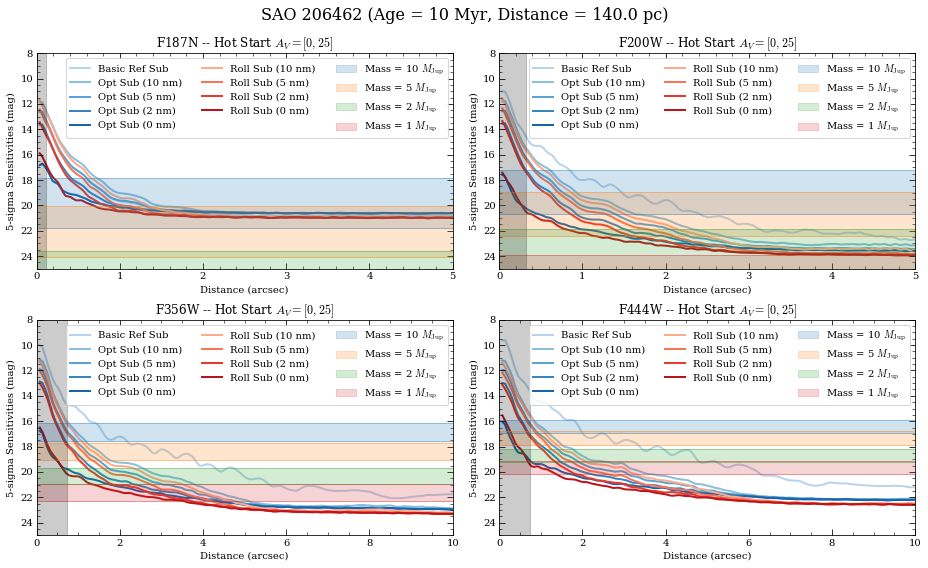

In [81]:
import matplotlib.patches as patches

fig, axes = plt.subplots(2,2, figsize=(13,8))
xlim1 = [0,5]
xlim2 = [0,10]
ylim  = [25,8]

curves_all = [curves_basic, curves_recon10, curves_recon5, curves_recon2, curves_photon]
labels = ['Basic Ref Sub', 'Opt Sub (10 nm)', 'Opt Sub (5 nm)', 
          'Opt Sub (2 nm)', 'Opt Sub (0 nm)']

lin_vals = np.linspace(0.2,0.7,len(curves_all))
cb = plt.cm.Blues_r(lin_vals)[::-1]

curves_all2 = [curves_noref10, curves_noref5, curves_noref2, curves_photon2]
labels2 = ['Roll Sub (10 nm)', 'Roll Sub (5 nm)', 
           'Roll Sub (2 nm)', 'Roll Sub (0 nm)']
lin_vals2 = np.linspace(0.2,0.7,len(curves_all2))
cr = plt.cm.Reds_r(lin_vals2)[::-1]

axes = axes.flatten()

for j, k in enumerate(filt_keys):
    for jj, cv in enumerate(curves_all):
        curves = cv[k]
        rr, contrast, mag_sens = curves[0]
        axes[j].plot(rr, mag_sens, color=cb[jj], zorder=1, lw=2, label=labels[jj])
    for jj, cv in enumerate(curves_all2):
        curves = cv[k]
        rr, contrast, mag_sens = curves[0]
        axes[j].plot(rr, mag_sens, color=cr[jj], zorder=1, lw=2, label=labels2[jj])
    
for j, ax in enumerate(axes):    
    ax.set_xlabel('Distance (arcsec)')
    ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))

    if j<2: ax.set_xlim(xlim1)
    else: ax.set_xlim(xlim2)
    ax.set_ylim(ylim)
    
    obs = obs_dict[filt_keys[j]]
    plot_planet_patches(ax, obs, age=age_sci)
    
    ax.legend(ncol=3)
    
# Saturation levels
for j, ax in enumerate(axes):
    dy = ylim[1] - ylim[0]
    
    rect = patches.Rectangle((0, ylim[0]), dmax[j], dy, alpha=0.2,
                             color='k', zorder=2)
    ax.add_patch(rect)

fig.tight_layout()

dist = obs.distance
age_str = 'Age = {:.0f} Myr'.format(age_sci)
dist_str = 'Distance = {:.1f} pc'.format(dist) if dist is not None else ''

fig.suptitle('{} ({}, {})'.format(name_sci,age_str,dist_str), fontsize=16);
#fig.subplots_adjust(top=0.85)
fig.subplots_adjust(top=0.9)

fname = "{}_contrast2.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)

## 2. TW Hya

[  8.27857683e-02   4.38870542e+02   2.49196394e+00]


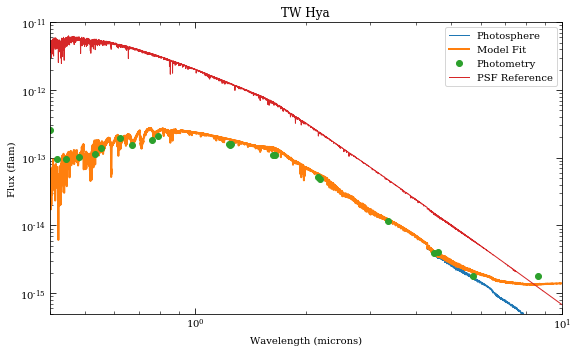

In [82]:
i = 1

name_sci, dist_sci, age_sci, spt_sci, vmag_sci, kmag_sci, w1_sci, w2_sci, vot = args_sources[i]
name_ref, spt_ref, kmag_ref = ref_sources[i]

# Science target and reference star spectra
sp_ref = pynrc.stellar_spectrum(spt_ref, kmag_ref, 'vegamag', bp_k)
sp_ref.name = name_ref

robust = True if i>=2 else False
sp_sci, (fig,ax) = gen_sp_sci(i, robust=robust, return_ax=True)

ax.plot(sp_ref.wave/1e4, sp_ref.flux, lw=1, label='PSF Reference')
ax.legend()
ax.set_xlim([0.4,10])
ax.set_ylim([5e-16,1e-11])

fname = "{}_spectra.pdf".format(name_sci.replace(" ", ""))
fig.savefig('YSOs/'+fname)

# Disk model information
# File name, arcsec/pix, dist (pc), wavelength (um), flux units
args_disk = None #('example_disk.fits', 0.007, 140.0, 1.6, 'mJy/arcsec^2')

In [83]:
obs_dict = do_init(args_disk=args_disk, fov_pix=401, verbose=False)

In [84]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',5,160,160)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')

### Saturation Regions

In [85]:
dmax = []
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    im_sat = obs.nrc_ref.saturation_levels(sp_ref,ngroup=0)

    dist = nrc_utils.dist_image(im_sat, pixscale=obs.pix_scale)
    dmax.append(dist[im_sat>0.8].max())

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


### Photon Limit Curves

In [86]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [0]

curves_photon = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


### Reference Reconstruction Curves

In [87]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [10]
curves_recon10 = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)

wfe_list = [5]
curves_recon5 = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)

wfe_list = [2]
curves_recon2 = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none
F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none
F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


### Basic PSF Subtraction Curves

In [88]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_ref

wfe_list = [5]

curves_basic = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


### Roll Subtraction

In [89]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',5,150,150)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')

In [90]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [0]

curves_photon2 = do_contrast(wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=10)

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


In [91]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [10]
curves_noref10 = do_contrast(wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=10)

wfe_list = [5]
curves_noref5 = do_contrast(wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=10)

wfe_list = [2]
curves_noref2 = do_contrast(wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=10)

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none
F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none
F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


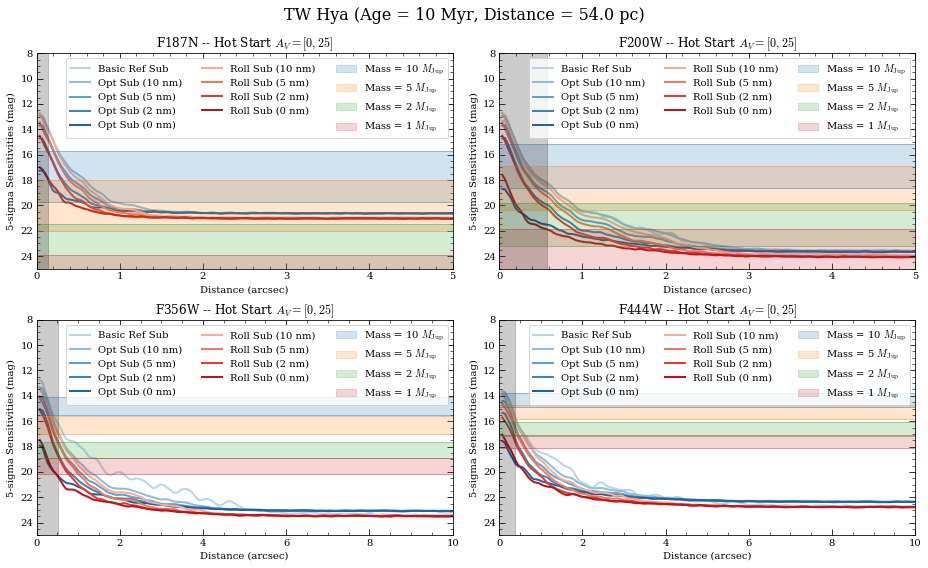

In [92]:
import matplotlib.patches as patches

fig, axes = plt.subplots(2,2, figsize=(13,8))
xlim1 = [0,5]
xlim2 = [0,10]
ylim  = [25,8]

curves_all = [curves_basic, curves_recon10, curves_recon5, curves_recon2, curves_photon]
labels = ['Basic Ref Sub', 'Opt Sub (10 nm)', 'Opt Sub (5 nm)', 
          'Opt Sub (2 nm)', 'Opt Sub (0 nm)']

lin_vals = np.linspace(0.2,0.7,len(curves_all))
cb = plt.cm.Blues_r(lin_vals)[::-1]

curves_all2 = [curves_noref10, curves_noref5, curves_noref2, curves_photon2]
labels2 = ['Roll Sub (10 nm)', 'Roll Sub (5 nm)', 
           'Roll Sub (2 nm)', 'Roll Sub (0 nm)']
lin_vals2 = np.linspace(0.2,0.7,len(curves_all2))
cr = plt.cm.Reds_r(lin_vals2)[::-1]

axes = axes.flatten()

for j, k in enumerate(filt_keys):
    for jj, cv in enumerate(curves_all):
        curves = cv[k]
        rr, contrast, mag_sens = curves[0]
        axes[j].plot(rr, mag_sens, color=cb[jj], zorder=1, lw=2, label=labels[jj])
    for jj, cv in enumerate(curves_all2):
        curves = cv[k]
        rr, contrast, mag_sens = curves[0]
        axes[j].plot(rr, mag_sens, color=cr[jj], zorder=1, lw=2, label=labels2[jj])
    
for j, ax in enumerate(axes):    
    ax.set_xlabel('Distance (arcsec)')
    ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))

    if j<2: ax.set_xlim(xlim1)
    else: ax.set_xlim(xlim2)
    ax.set_ylim(ylim)
    
    obs = obs_dict[filt_keys[j]]
    plot_planet_patches(ax, obs, age=age_sci)
    
    ax.legend(ncol=3)
    
# Saturation levels
for j, ax in enumerate(axes):
    dy = ylim[1] - ylim[0]
    
    rect = patches.Rectangle((0, ylim[0]), dmax[j], dy, alpha=0.2,
                             color='k', zorder=2)
    ax.add_patch(rect)

fig.tight_layout()

dist = obs.distance
age_str = 'Age = {:.0f} Myr'.format(age_sci)
dist_str = 'Distance = {:.1f} pc'.format(dist) if dist is not None else ''

fig.suptitle('{} ({}, {})'.format(name_sci,age_str,dist_str), fontsize=16);
#fig.subplots_adjust(top=0.85)
fig.subplots_adjust(top=0.9)

fname = "{}_contrast2.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)

## 3. MWC 758

[  1.64168384e-01   2.98052913e+03   1.64704399e+00]


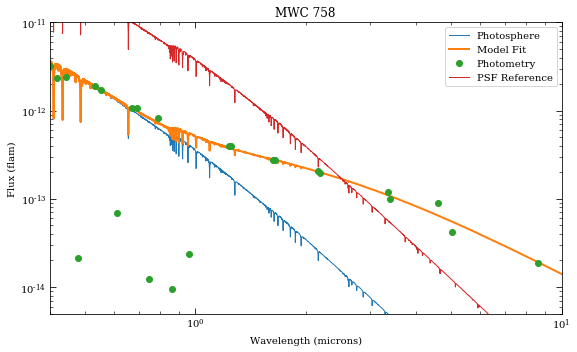

In [93]:
i = 2

name_sci, dist_sci, age_sci, spt_sci, vmag_sci, kmag_sci, w1_sci, w2_sci, vot = args_sources[i]
name_ref, spt_ref, kmag_ref = ref_sources[i]

# Science target and reference star spectra
sp_ref = pynrc.stellar_spectrum(spt_ref, kmag_ref, 'vegamag', bp_k)
sp_ref.name = name_ref

robust = True if i>=2 else False
sp_sci, (fig,ax) = gen_sp_sci(i, robust=robust, return_ax=True)

ax.plot(sp_ref.wave/1e4, sp_ref.flux, lw=1, label='PSF Reference')
ax.legend()
ax.set_xlim([0.4,10])
ax.set_ylim([5e-15,1e-11])

fname = "{}_spectra.pdf".format(name_sci.replace(" ", ""))
fig.savefig('YSOs/'+fname)

# Disk model information
# File name, arcsec/pix, dist (pc), wavelength (um), flux units
args_disk = ('example_disk.fits', 0.007, 140.0, 1.6, 'mJy/arcsec^2')

In [94]:
obs_dict = do_init(args_disk=args_disk, fov_pix=401, verbose=False)

In [95]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',5,160,160)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')

### Saturation Regions

In [96]:
dmax = []
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    im_sat = obs.nrc_ref.saturation_levels(sp_ref,ngroup=0)

    dist = nrc_utils.dist_image(im_sat, pixscale=obs.pix_scale)
    dmax.append(dist[im_sat>0.8].max())

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


### Photon Limit Curves

In [97]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [0]

curves_photon = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


### Reference Reconstruction Curves

In [98]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [10]
curves_recon10 = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)

wfe_list = [5]
curves_recon5 = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)

wfe_list = [2]
curves_recon2 = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none
F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none
F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


### Basic PSF Subtraction Curves

In [99]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_ref

wfe_list = [5]

curves_basic = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


### Roll Subtraction

In [100]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',5,135,135)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')

In [101]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [0]

curves_photon2 = do_contrast(wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=10)

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


In [102]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [10]
curves_noref10 = do_contrast(wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=10)

wfe_list = [5]
curves_noref5 = do_contrast(wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=10)

wfe_list = [2]
curves_noref2 = do_contrast(wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=10)

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none
F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none
F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


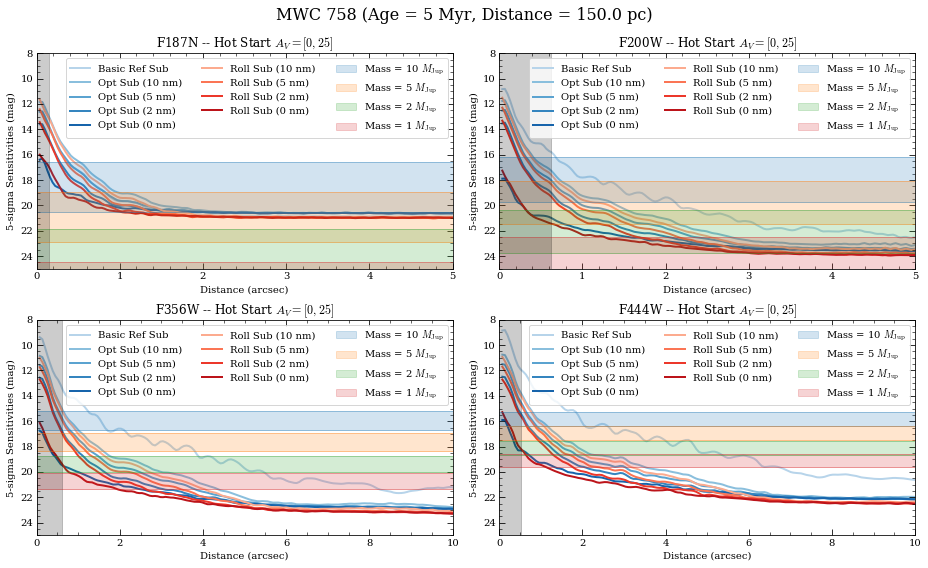

In [103]:
import matplotlib.patches as patches

fig, axes = plt.subplots(2,2, figsize=(13,8))
xlim1 = [0,5]
xlim2 = [0,10]
ylim  = [25,8]

curves_all = [curves_basic, curves_recon10, curves_recon5, curves_recon2, curves_photon]
labels = ['Basic Ref Sub', 'Opt Sub (10 nm)', 'Opt Sub (5 nm)', 
          'Opt Sub (2 nm)', 'Opt Sub (0 nm)']

lin_vals = np.linspace(0.2,0.7,len(curves_all))
cb = plt.cm.Blues_r(lin_vals)[::-1]

curves_all2 = [curves_noref10, curves_noref5, curves_noref2, curves_photon2]
labels2 = ['Roll Sub (10 nm)', 'Roll Sub (5 nm)', 
           'Roll Sub (2 nm)', 'Roll Sub (0 nm)']
lin_vals2 = np.linspace(0.2,0.7,len(curves_all2))
cr = plt.cm.Reds_r(lin_vals2)[::-1]

axes = axes.flatten()

for j, k in enumerate(filt_keys):
    for jj, cv in enumerate(curves_all):
        curves = cv[k]
        rr, contrast, mag_sens = curves[0]
        axes[j].plot(rr, mag_sens, color=cb[jj], zorder=1, lw=2, label=labels[jj])
    for jj, cv in enumerate(curves_all2):
        curves = cv[k]
        rr, contrast, mag_sens = curves[0]
        axes[j].plot(rr, mag_sens, color=cr[jj], zorder=1, lw=2, label=labels2[jj])
    
for j, ax in enumerate(axes):    
    ax.set_xlabel('Distance (arcsec)')
    ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))

    if j<2: ax.set_xlim(xlim1)
    else: ax.set_xlim(xlim2)
    ax.set_ylim(ylim)
    
    obs = obs_dict[filt_keys[j]]
    plot_planet_patches(ax, obs, age=age_sci)
    
    ax.legend(ncol=3)
    
# Saturation levels
for j, ax in enumerate(axes):
    dy = ylim[1] - ylim[0]
    
    rect = patches.Rectangle((0, ylim[0]), dmax[j], dy, alpha=0.2,
                             color='k', zorder=2)
    ax.add_patch(rect)

fig.tight_layout()

dist = obs.distance
age_str = 'Age = {:.0f} Myr'.format(age_sci)
dist_str = 'Distance = {:.1f} pc'.format(dist) if dist is not None else ''

fig.suptitle('{} ({}, {})'.format(name_sci,age_str,dist_str), fontsize=16);
#fig.subplots_adjust(top=0.85)
fig.subplots_adjust(top=0.9)

fname = "{}_contrast2.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)

## 4. HL Tau

[  2.37592190e-02   2.47428825e+03   2.84970482e+00]


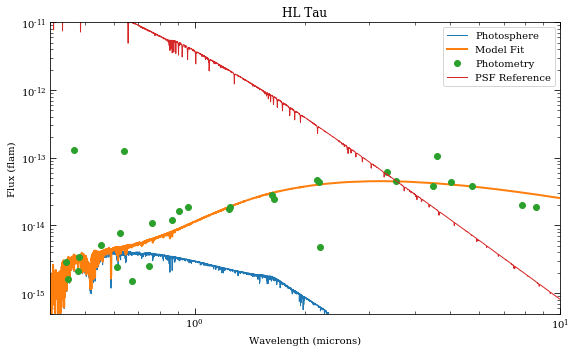

In [59]:
i = 3

name_sci, dist_sci, age_sci, spt_sci, vmag_sci, kmag_sci, w1_sci, w2_sci, vot = args_sources[i]
name_ref, spt_ref, kmag_ref = ref_sources[i]

# Science target and reference star spectra
sp_ref = pynrc.stellar_spectrum(spt_ref, kmag_ref, 'vegamag', bp_k)
sp_ref.name = name_ref

robust = True if i>=2 else False
sp_sci, (fig,ax) = gen_sp_sci(i, robust=robust, return_ax=True)

ax.plot(sp_ref.wave/1e4, sp_ref.flux, lw=1, label='PSF Reference')
ax.legend()
ax.set_xlim([0.4,10])
ax.set_ylim([5e-16,1e-11])

fname = "{}_spectra.pdf".format(name_sci.replace(" ", ""))
fig.savefig('YSOs/'+fname)

# Disk model information
# File name, arcsec/pix, dist (pc), wavelength (um), flux units
args_disk = None #('example_disk.fits', 0.007, 140.0, 1.6, 'mJy/arcsec^2')

In [60]:
obs_dict = do_init(args_disk=args_disk, fov_pix=401, verbose=False)

In [61]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',5,160,160)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')

### Saturation Regions

In [62]:
dmax = []
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    im_sat = obs.saturation_levels(ngroup=0)

    dist = nrc_utils.dist_image(im_sat, pixscale=obs.pix_scale)
    dmax.append(dist[im_sat>0.8].max())

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


### Photon Limit Curves

In [63]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [0]

curves_photon = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)


F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


### Reference Reconstruction Curves

In [64]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [10]
curves_recon10 = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)

wfe_list = [5]
curves_recon5 = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)

wfe_list = [2]
curves_recon2 = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none
F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none
F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


### Basic PSF Subtraction Curves

In [65]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_ref

wfe_list = [5]

curves_basic = do_contrast(wfe_list, filt_keys, nsig=nsig, opt_diff=True)

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


### Roll Subtraction

In [66]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',5,150,150)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')

In [67]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [0]

curves_photon2 = do_contrast(wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=10)

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


In [68]:
nsig = 5

for k in filt_keys:
    obs_dict[k].sp_ref = sp_sci

wfe_list = [10]
curves_noref10 = do_contrast(wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=10)

wfe_list = [5]
curves_noref5 = do_contrast(wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=10)

wfe_list = [2]
curves_noref2 = do_contrast(wfe_list, filt_keys, nsig=nsig, no_ref=True, roll_angle=10)

F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none
F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none
F187N_none_none
F200W_none_none
F356W_none_none
F444W_none_none


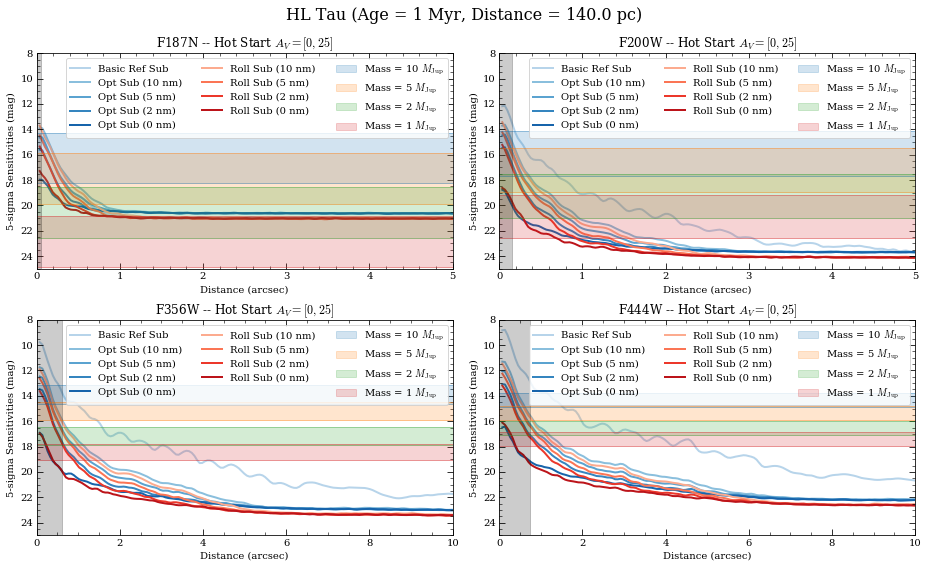

In [70]:
import matplotlib.patches as patches

fig, axes = plt.subplots(2,2, figsize=(13,8))
xlim1 = [0,5]
xlim2 = [0,10]
ylim  = [25,8]

curves_all = [curves_basic, curves_recon10, curves_recon5, curves_recon2, curves_photon]
labels = ['Basic Ref Sub', 'Opt Sub (10 nm)', 'Opt Sub (5 nm)', 
          'Opt Sub (2 nm)', 'Opt Sub (0 nm)']

lin_vals = np.linspace(0.2,0.7,len(curves_all))
cb = plt.cm.Blues_r(lin_vals)[::-1]

curves_all2 = [curves_noref10, curves_noref5, curves_noref2, curves_photon2]
labels2 = ['Roll Sub (10 nm)', 'Roll Sub (5 nm)', 
           'Roll Sub (2 nm)', 'Roll Sub (0 nm)']
lin_vals2 = np.linspace(0.2,0.7,len(curves_all2))
cr = plt.cm.Reds_r(lin_vals2)[::-1]

axes = axes.flatten()

for j, k in enumerate(filt_keys):
    for jj, cv in enumerate(curves_all):
        curves = cv[k]
        rr, contrast, mag_sens = curves[0]
        axes[j].plot(rr, mag_sens, color=cb[jj], zorder=1, lw=2, label=labels[jj])
    for jj, cv in enumerate(curves_all2):
        curves = cv[k]
        rr, contrast, mag_sens = curves[0]
        axes[j].plot(rr, mag_sens, color=cr[jj], zorder=1, lw=2, label=labels2[jj])
    
for j, ax in enumerate(axes):    
    ax.set_xlabel('Distance (arcsec)')
    ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))

    if j<2: ax.set_xlim(xlim1)
    else: ax.set_xlim(xlim2)
    ax.set_ylim(ylim)
    
    obs = obs_dict[filt_keys[j]]
    plot_planet_patches(ax, obs, age=age_sci)
    
    ax.legend(ncol=3)
    
# Saturation levels
for j, ax in enumerate(axes):
    dy = ylim[1] - ylim[0]
    
    rect = patches.Rectangle((0, ylim[0]), dmax[j], dy, alpha=0.2,
                             color='k', zorder=2)
    ax.add_patch(rect)

fig.tight_layout()

dist = obs.distance
age_str = 'Age = {:.0f} Myr'.format(age_sci)
dist_str = 'Distance = {:.1f} pc'.format(dist) if dist is not None else ''

fig.suptitle('{} ({}, {})'.format(name_sci,age_str,dist_str), fontsize=16);
#fig.subplots_adjust(top=0.85)
fig.subplots_adjust(top=0.9)

fname = "{}_contrast2.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)